In [1]:
## ---- Global Cell Set Doublet Testing with DoubletDecon ---- 0687.02.00
## Load aggregated data set (previously unprocessed 10x data)
## Filter to downsampled and remixed data sets (remove QC failed cells too)
## Perform DoubletDecon analysis
## Save doublet scores, predicted doublets, and cell barcodes

In [2]:
# if(!require(devtools)){
#   install.packages("devtools") # If not already installed
# }
# devtools::install_github('EDePasquale/DoubletDecon')

In [1]:
# lpath <- "/gpfs/group/torkamani/devans/Rmodules.DoubletDecon/3.5/"
# if (!(lpath %in% .libPaths())) .libPaths(c(lpath, .libPaths()))   
privpath <- .libPaths()[1]
pubpath <- .libPaths()[2]
ddpath <- '/gpfs/group/torkamani/devans/Rmodules/DoubletDecon'
Seuratpath <- '/gpfs/group/torkamani/devans/Rmodules/Seurat'

In [7]:
# .libPaths(ddpath) 
library(DoubletDecon)
# .libPaths(pubpath) 
library(DeconRNASeq)
library(gplots)
library(dplyr)
library(reticulate)
library(MCL)
library(clusterProfiler)
library(mygene)
library(tidyr)
library(R.utils)
library(foreach)
library(doParallel)
library(stringr)
library(Seurat)
library(irlba)
library(patchwork)

In [8]:
## Create a Working Input and Output Data Directory, If It Does Not Exist
parentdir <- '/gpfs/group/torkamani/devans/'
datdir <- paste(parentdir, 'CDC2', sep = '')
if (!file.exists(datdir)) {
    dir.create(datdir)
}
setwd(datdir)

In [9]:
## Read the parameters file
ps <- read.table(file = 'parms.txt', stringsAsFactors = FALSE, header = TRUE)

In [10]:
## Read the downsampled and remixed cell barcodes and partition names
remix_codes <- read.table(file = 'outputdat/Remix_Codes.Rev1.txt',
                          header = FALSE, stringsAsFactors = FALSE)

In [11]:
## Remove the previously identified partitions that were marked as failed or too small
remix_keepers <- remix_codes[(remix_codes$V3 != 'FAILQC2.1.4.11-15'), ]
table(remix_keepers$V3)


BLYMPH.10   CYTOT.9  ENDO.3.6   MACRO.2     NKC.8  VSMC.5.7 
      523      4944      3130      3094       370      4226 

In [12]:
# Point to the aggregated single cell data
input_dir <- '/gpfs/group/torkamani/devans/CDC2/inputdat/outs/filtered_feature_bc_matrix'

In [13]:
## Read the aggregated samples
agg_cds1 <- Read10X(data.dir = input_dir)

In [14]:
agg_cds <- agg_cds1

In [33]:
dim(agg_cds)
colnames(agg_cds)[1:10]
str(agg_cds)
sum(colnames(agg_cds) %in% remix_keepers$V2)
length(colnames(agg_cds) %in% remix_keepers$V2)
remix_cds <- agg_cds[, (colnames(agg_cds) %in% remix_keepers$V2)]
dim(remix_cds)

[1] 33538 51981

[1] "AAACGAAAGATCCCAT-1" "AAACGAACAGGCTACC-1" "AAACGAAGTACAAGCG-1"
 [4] "AAACGAAGTATGTCCA-1" "AAACGAATCCTGCTAC-1" "AAACGAATCTCTAAGG-1"
 [7] "AAACGCTAGATGCTTC-1" "AAACGCTAGCTGGCTC-1" "AAACGCTCAACCCGCA-1"
[10] "AAACGCTGTCACTCTC-1"

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:79019023] 39 47 53 55 61 66 89 94 102 119 ...
  ..@ p       : int [1:51982] 0 2325 3970 5371 5824 7653 8262 8305 9129 13119 ...
  ..@ Dim     : int [1:2] 33538 51981
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:33538] "MIR1302-2HG" "FAM138A" "OR4F5" "AL627309.1" ...
  .. ..$ : chr [1:51981] "AAACGAAAGATCCCAT-1" "AAACGAACAGGCTACC-1" "AAACGAAGTACAAGCG-1" "AAACGAAGTATGTCCA-1" ...
  ..@ x       : num [1:79019023] 1 1 2 2 1 1 2 2 1 1 ...
  ..@ factors : list()


[1] 16287

[1] 51981

[1] 33538 16287

In [35]:
agg_cds <- CreateSeuratObject(counts = remix_cds, project = "remix_cds", min.cells = 3, min.features = 200)

In [36]:
# agg_cds[["percent.mt"]] <- PercentageFeatureSet(agg_cds, pattern = "^MT-")
# agg_cds <- subset(agg_cds, subset = nFeature_RNA > 200 & nFeature_RNA < 4000 & percent.mt < 5)

In [37]:
agg_cds <- NormalizeData(agg_cds)

In [38]:
agg_cds <- FindVariableFeatures(object = agg_cds, selection.method = "vst")

In [39]:
all.genes <- rownames(agg_cds)
agg_cds <- ScaleData(agg_cds, features = all.genes)

Centering and scaling data matrix



In [40]:
agg_cds  <- RunPCA(agg_cds , features = VariableFeatures(object = agg_cds ))

PC_ 1 
Positive:  IGFBP7, MGP, CALD1, SELENOM, DSTN, ADIRF, SOD3, C1R, CLU, MYL9 
	   GSN, IGFBP5, TPM1, SERPING1, PLAC9, OGN, CAVIN3, COL6A2, SPARCL1, NNMT 
	   CRYAB, BGN, CPE, AEBP1, EFEMP1, SPARC, TAGLN, CTGF, CD151, LHFPL6 
Negative:  SRGN, LAPTM5, TYROBP, CYBA, FCER1G, AIF1, ITGB2, VAMP8, LYZ, CTSS 
	   PLEK, COTL1, C5AR1, GPR183, CYBB, SPI1, MS4A6A, CD14, MNDA, LST1 
	   CD83, IGSF6, MS4A7, C1orf162, SERPINA1, CLEC7A, SAT1, CD68, SH3BGRL3, BCL2A1 
PC_ 2 
Positive:  CST3, PSAP, FTL, CD68, AIF1, FTH1, CD14, NPC2, C5AR1, FCER1G 
	   CTSB, GRN, CFD, TMEM176B, BLVRB, LYZ, CEBPD, MS4A6A, FCGRT, FGL2 
	   CPVL, TYROBP, MS4A7, PLAUR, SPI1, IGSF6, FCGR2A, CTSZ, MNDA, CYBB 
Negative:  IL32, CD69, TRBC2, CD2, CD3D, TRAC, CD3G, CCL5, GZMA, IL7R 
	   CST7, LTB, CD52, TRBC1, GZMK, NKG7, CTSW, CD247, CD7, DUSP2 
	   GZMH, KLRB1, SOCS1, CD8A, CCR7, HOPX, PRF1, CD8B, KLRD1, GNLY 
PC_ 3 
Positive:  S100A4, CD69, TRAC, IL32, CD2, CD52, TRBC2, CCL5, CD3D, GZMA 
	   CD3G, C12orf75, CST7, IL7R, DUSP2

In [41]:
agg_cds <- FindNeighbors(agg_cds, dims = 1:10)
agg_cds <- FindClusters(agg_cds, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 16287
Number of edges: 531511

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9288
Number of communities: 13
Elapsed time: 3 seconds


In [42]:
agg_cds <- RunUMAP(agg_cds, dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
08:52:02 UMAP embedding parameters a = 0.9922 b = 1.112

08:52:02 Read 16287 rows and found 10 numeric columns

08:52:02 Using Annoy for neighbor search, n_neighbors = 30

08:52:02 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

08:52:08 Writing NN index file to temp file /scratch/RtmpDtL7eB/file17e965a204694

08:52:08 Searching Annoy index using 1 thread, search_k = 3000

08:52:15 Annoy recall = 100%

08:52:16 Commencing smooth kNN distance calibration using 1 thread

08:52:19 Initializ

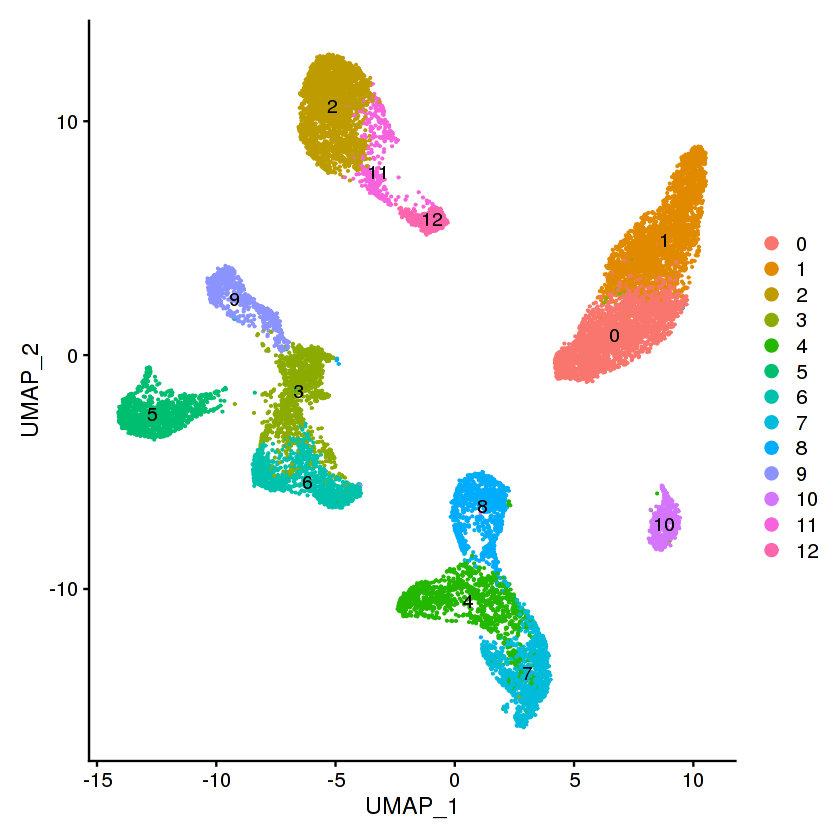

In [52]:
DimPlot(agg_cds, reduction = "umap", label = TRUE)

In [44]:
## Save the Seurat cell R data object
saveRDS(agg_cds, file = '/gpfs/group/torkamani/devans/CDC2/outputdat/ddcon.rev2.rds')

In [45]:
newFiles1 <- Improved_Seurat_Pre_Process(agg_cds, num_genes=50, write_files=FALSE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Warning message:
“The following arguments are not used: thresh.use”


In [46]:
newFiles <- newFiles1

Loading packages...
Reading data...
Processing raw data...
Creating original data heatmap...
Combining similar clusters...


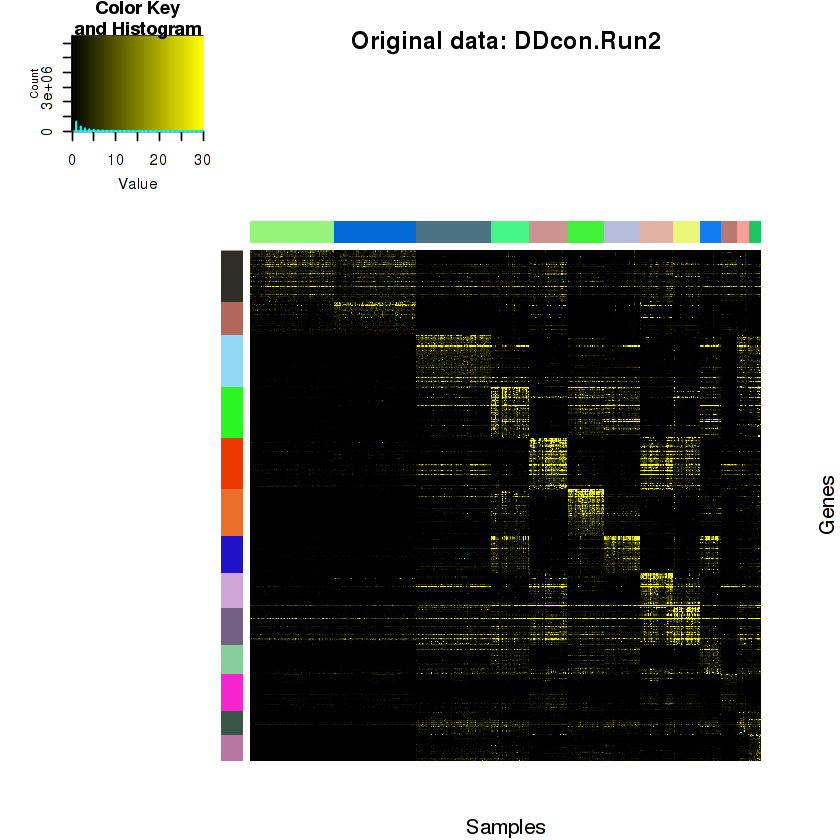

Creating synthetic doublet profiles...
Step 1: Removing possible doublets...
Step 2: Re-clustering possible doublets...
Step 3: Rescuing cells with unique gene expression...
Creating doublets heatmap...


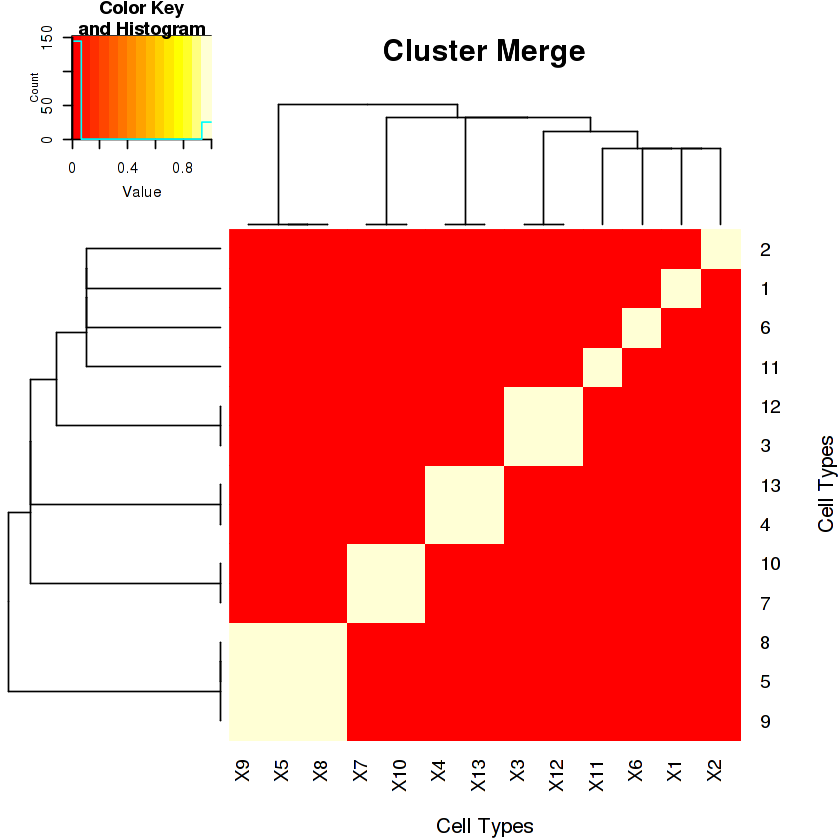

Creating non-doublets heatmap...


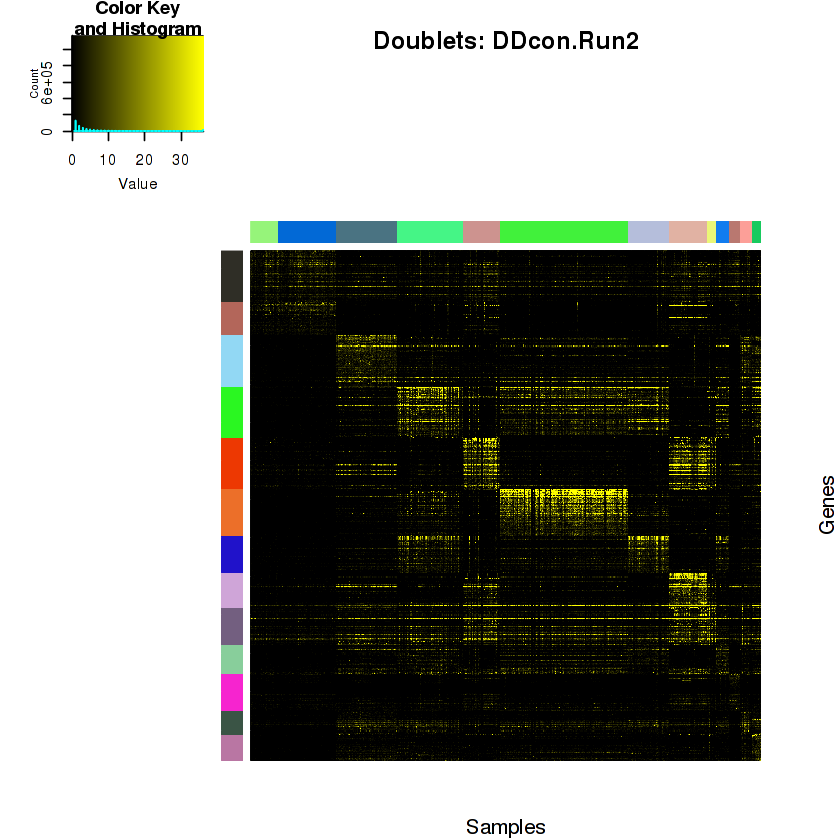

Finished!


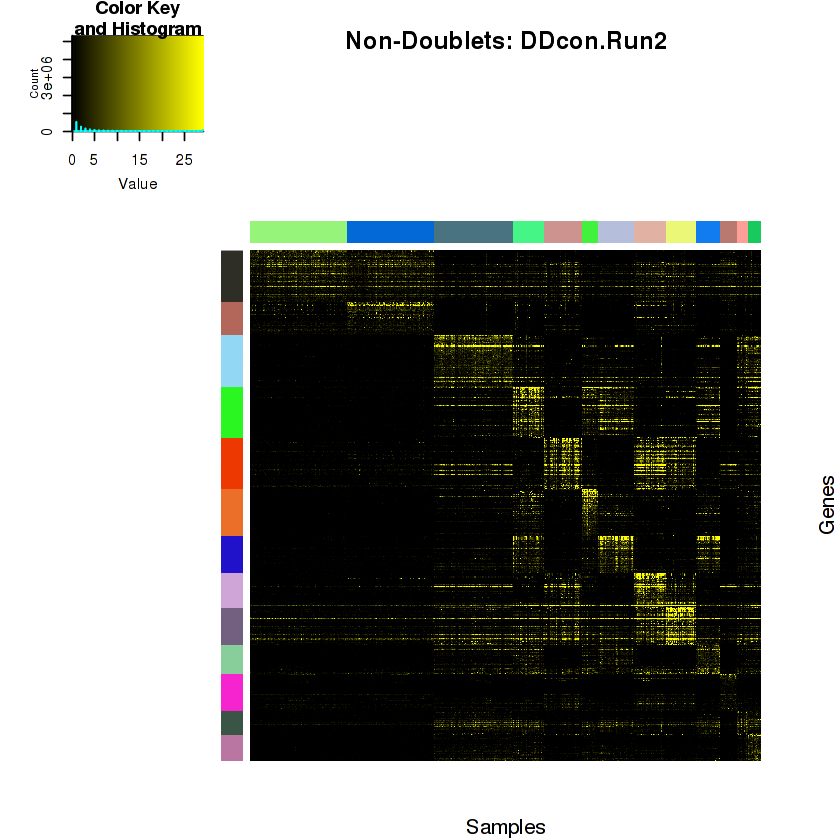

In [49]:
results1 <- Main_Doublet_Decon(rawDataFile=newFiles$newExpressionFile, 
                           groupsFile=newFiles$newGroupsFile, 
                           filename= 'DDcon.Run2', 
                           location= '/gpfs/group/torkamani/devans/CDC2/outputdat/DDcon/Rev2/',
                           fullDataFile=NULL, 
                           removeCC=FALSE, 
                           species="hsa", 
                           rhop=1.1, 
                           write=TRUE, 
                           PMF=TRUE, 
                           useFull=FALSE, 
                           heatmap=TRUE,
                           centroids=TRUE,
                           num_doubs=100, 
                           only50=FALSE,
                           min_uniq=4,
                           nCores=1)

In [69]:
## Get the Seurat UMAP embeddeds
umap_embedding <- agg_cds@reductions$umap@cell.embeddings

In [119]:
## Get the Seurat cluster info
umap_clusters <- as.matrix(agg_cds@active.ident)
rownames(umap_clusters) <- c(names(agg_cds@active.ident))
colnames(umap_clusters) <- 'cluster_id'

In [122]:
## Write the Seurat UMAP embedding and cluster ids 
write.table(umap_embedding,
            file = paste(ps$outdir, '/DDcon/Rev2/UMAP.Embedding.txt', sep = ''),
            quote = FALSE, col.names = TRUE, row.names = TRUE)
write.table(umap_clusters,
            file = paste(ps$outdir, '/DDcon/Rev2/Clusters.txt', sep = ''),
            quote = FALSE, col.names = TRUE, row.names = TRUE)

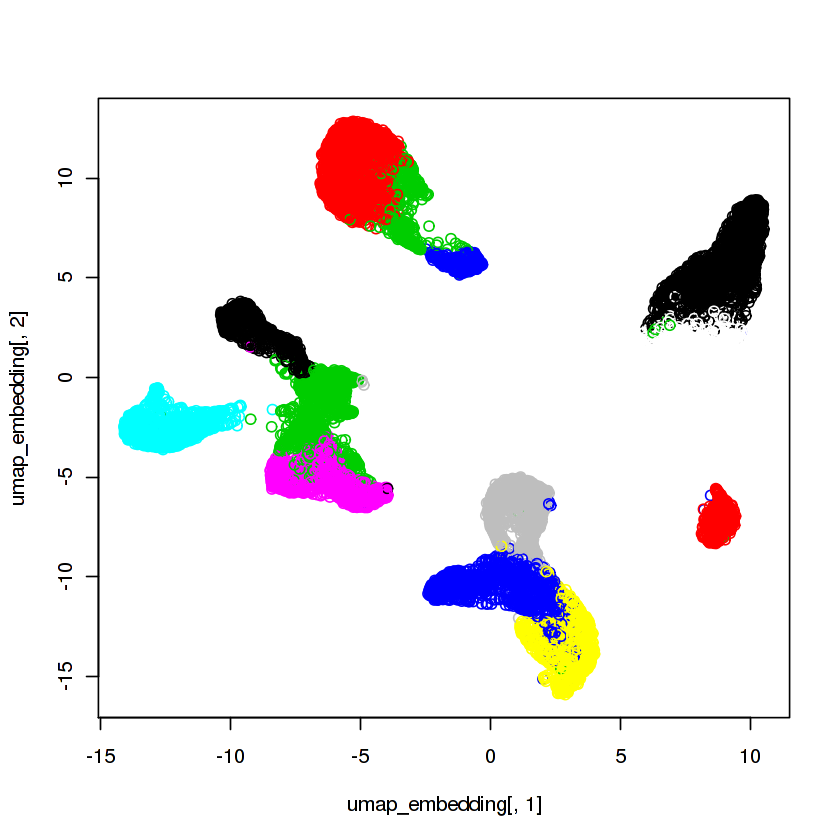

In [124]:
## Test plot the Seurat clusters
plot(x = umap_embedding[,1], umap_embedding[,2], col = umap_clusters)

In [2]:
dim(agg_cds)

ERROR: Error in eval(expr, envir, enclos): object 'agg_cds' not found
